In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.decomposition import PCA as sklearnPCA
import seaborn as sns
import IPython 
import glob
import yfinance as yf
from scipy.optimize import minimize
import datetime
import scipy.optimize as sco
from scipy import stats

plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def calc_portfolio_std(weights, mean_returns, cov): #計算投資組合Volatility
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def min_variance(mean_returns, cov): #計算有最低Volatility的投資組合
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [3]:
#下載歷史資料函數
def stock_adjclose(Tickers, start_y = 1900, start_m = 1, start_d = 1, end_y = 2040, end_m = 12, end_d = 31):
    start = datetime.datetime(start_y, start_m, start_d).strftime("%Y-%m-%d")
    end = datetime.datetime(end_y, end_m, end_d).strftime("%Y-%m-%d")
    data = yf.download(Tickers, start, end)
    data = data[['Adj Close', 'Volume']]
    data = data.round(decimals=2) 
    return data


In [4]:
#下載VIX歷史資料並計算指標
VIX = stock_adjclose("^VIX", 2005, 1, 2, 2020, 6, 1)["Adj Close"]
VIX_90Q = VIX.rolling(120).quantile(0.9).ffill()
VIX_10Q = VIX.rolling(120).quantile(0.1).ffill()
VIQ90 = (VIX > VIX_90Q) & (VIX.shift(1) < VIX_90Q.shift(1))
VIQ10 = (VIX < VIX_10Q) & (VIX.shift(1) > VIX_10Q.shift(1))
VIW90 = (VIX < VIX_90Q) & (VIX.shift(1) > VIX_90Q.shift(1)) 

[*********************100%***********************]  1 of 1 completed


In [5]:
#股票ETF Tickers
Tickers = ["RWR", "XLB","XLI","XLY","XLP","XLE","XLF","XLU","XLV","XLK","IYT",'VTV','VOE','VBR','VEA','VWO', "FXI","EWH","EWJ","EWY","EWS","EWT"]

In [6]:
#下載資產池歷史資料
data = stock_adjclose(Tickers, 2005, 1, 2, 2020, 6, 1)
df = data["Adj Close"]
TLT = stock_adjclose("TLT", 2005, 1, 2, 2020, 6, 1)

[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
#計算日報酬率
df_R = df.pct_change().dropna()

In [8]:
#計算相對高度
df_L = df.rolling(window = 120).min()
df_H = df.rolling(window = 120).max()
df_CH = (df - df_L)/(df_H - df_L)

In [9]:
#將報酬率乘上根號ADV(Average Daily Transaction Volume)
data_R_MVW = (df_R.shift(1)).mul(np.sqrt(data["Volume"]*data["Adj Close"])).dropna()

In [10]:
#建構衰減矩陣
decay = [np.geomspace(1/4, 1, num=500, dtype=float)]*len(Tickers)
decay_frame = pd.DataFrame(decay).transpose()
decay_frame.columns = df.columns
decay_frame.head()

,EWH,EWJ,EWS,EWT,EWY,FXI,IYT,RWR,VBR,VEA,VOE,VTV,VWO,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
1,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696,0.250696
2,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393,0.251393
3,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092,0.252092
4,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794,0.252794


In [11]:
#計算各股票型ETF每日的資產集中度
date = []
C = []
for i in range(len(data_R_MVW.index) - 500):
    c = []
    decay_frame.index = data_R_MVW[i:500+i].index
    date.append(data_R_MVW.index[500+i-1])
    temp = (data_R_MVW[i:500+i].mul(decay_frame))
    cov = np.array(temp.cov())
    sklearn_pca = sklearnPCA(n_components=2)
    pc = sklearn_pca.fit_transform(temp)
    AR = sklearn_pca.explained_variance_ratio_
    pcs = sklearn_pca.components_
    pcv = sklearn_pca.singular_values_
    
    eigValue = np.abs(np.array(pcv))
    eigVector = np.abs(np.array(pcs))
    
    AR1 = AR[0]
    AR2 = AR[1]
    
    Es1 = np.sum(eigVector[0])
    Es2 = np.sum(eigVector[1])
    
    for j in range(len(Tickers)):
        c_temp = (AR1*(eigVector[0][j])/Es1+AR2*(eigVector[1][j])/Es2)/(AR1 + AR2)
        r1 = (eigVector[0][j])/Es1
        r2 = (eigVector[1][j])/Es2
        c.append(c_temp)
        
    C.append(c)
    
Cen = pd.DataFrame(C)
Cen.index = date
Cen.index.name = "Date"
Cen.columns = df.columns

In [12]:
# 將資產集中度以過去3年平均與標準差標準化
MA = (Cen.rolling(window=750).mean()).dropna()
MD = (Cen.rolling(window=750).std()).dropna()
Cen_nor = Cen.sub(MA)
Cen_nor = Cen_nor.div(MD).dropna()

In [13]:
# 依標準化後的資產集中度，計算各股票型ETF每日的Expected Return
Ers = []
for j in Cen_nor.index:
    Er = []
    Cen_Array = Cen_nor.loc[j]
    CH_Array = df_CH.loc[j]
    
    C_rank = np.array(Cen_Array.rank(axis = 0, ascending = False))
    CH_rank = np.array(CH_Array.rank(axis = 0, ascending = False))
    NUM = 5
    for i in range(len(C_rank)):
        if (C_rank[i] <= NUM and CH_rank[i] <= NUM):
            Er.append(-0.05)
        elif (C_rank[i] > NUM and CH_rank[i] > NUM):
            Er.append(0)
        elif (C_rank[i] <= NUM and CH_rank[i] > NUM):
            Er.append(0.05)
        elif (C_rank[i] > NUM and CH_rank[i] <= NUM):
            Er.append(0)
    Ers.append(Er)
    
Ers_df = pd.DataFrame(Ers, columns = Cen_nor.columns)
Ers_df.index = Cen_nor.index

In [14]:
#依每日的Expected Return，與過去2兩年Volatility，計算股票型ETF有最小Volatility的投資組合
#這一步會跑比較久
weights = []
for i in Ers_df.index:
    mean_returns = Ers_df.loc[i]
    base = df.index.get_loc(i)
    cov = df.pct_change()[base - 500:base].dropna().cov()
    rf = 0.0
    min_port_variance = min_variance(mean_returns, cov)
    
    weights.append([round(x,2) for x in min_port_variance['x']])

W = pd.DataFrame(weights, columns = df.columns, index = Ers_df.index)

In [15]:
#以過去60日的平均權重作為隔日權重
W_mean = W.shift(1).dropna().rolling(60).mean().dropna()

In [16]:
#依VIX指標計算股票型ETF、債券型ETF每日的權重
W_mean_b = W_mean.copy()
W_mean_b["VIQ90"] = VIQ90
W_mean_b["VIQ10"] = VIQ10
W_mean_b["VIW90"] = VIW90
W_mean_b["TLT"] = 0
for i in range(1, len(W_mean_b)):
    temp =  W_mean_b.iloc[i]
    temp["TLT"] = W_mean_b.iloc[i - 1]["TLT"]
    W_mean_b.iloc[i] = temp
    if W_mean_b.iloc[i]["VIQ90"] == True:
        temp =  W_mean_b.iloc[i]
        temp["TLT"] = 1
        W_mean_b.iloc[i] = temp
    if W_mean_b.iloc[i]["VIW90"] == True:
        temp =  W_mean_b.iloc[i]
        temp["TLT"] = 0
        W_mean_b.iloc[i] = temp
    if W_mean_b.iloc[i]["VIQ10"] == True:
        temp =  W_mean_b.iloc[i]
        temp["TLT"] = (W_mean_b.iloc[i - 1]["TLT"] + 0.01)
        W_mean_b.iloc[i] = temp
        
W_mean_b = W_mean_b.drop(["VIQ90","VIQ10","VIW90"], axis = 1)
portfolio_weight = W_mean_b[W_mean.columns].mul(1 - W_mean_b["TLT"], axis = 0)
portfolio_weight["TLT"] =W_mean_b["TLT"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_laun

In [17]:
#計算投資組合日報酬
df_temp = df.copy()
df_temp["TLT"] = TLT["Adj Close"]
portfolio_return = portfolio_weight.mul(df_temp.pct_change()).dropna().sum(axis = 1)

In [18]:
#下載Benchmark資料
SPY = stock_adjclose("SPY", portfolio_return.index[0].year, portfolio_return.index[0].month, portfolio_return.index[0].day, (portfolio_return.index[-1] + datetime.timedelta(days = 1)).year, (portfolio_return.index[-1] + datetime.timedelta(days = 1)).month, (portfolio_return.index[-1] + datetime.timedelta(days = 1)).day)["Adj Close"]
SPY_r = (SPY.pct_change().dropna())

[*********************100%***********************]  1 of 1 completed


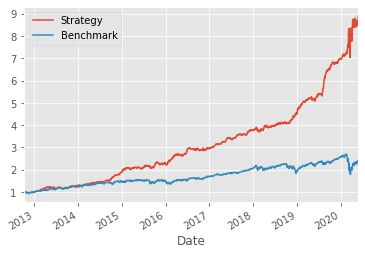

In [19]:
#繪製績效圖
F = pd.concat([(portfolio_return + 1).cumprod(), (SPY_r + 1).cumprod()], axis=1).dropna()
F.columns = ["Strategy", "Benchmark"]
F = F.reset_index()
F.plot(x = "Date" ,y = ["Strategy", "Benchmark"])

In [20]:
#計算報酬率、標準差、夏普比率、最大回檔
annualized_return = (F["Strategy"].iloc[-1])**(252/len(F["Strategy"])) - 1
annualized_std = (portfolio_return).std()* np.sqrt(252)
sharpe_ratio = (annualized_return - rf) / annualized_std

Benchmark_return = (F["Benchmark"].iloc[-1])**(252/len(F["Benchmark"])) - 1
Benchmark_std = (SPY_r).std()* np.sqrt(252)
Benchmark_sharpe_ratio = (Benchmark_return - rf) / Benchmark_std
MDD = ((F["Strategy"].cummax() - F["Strategy"])/F["Strategy"].cummax()).max()
Benchmark_MDD = ((F["Benchmark"].cummax() - F["Benchmark"])/F["Benchmark"].cummax()).max()


In [21]:
print("策略績效")
print("年化報酬率:", annualized_return)
print("年化標準差:", annualized_std)
print("夏普比率:", sharpe_ratio)
print("最大回檔:", MDD)
print("--------------------------------")
print("Benchmark績效")
print("年化報酬率:", Benchmark_return)
print("年化標準差:", Benchmark_std)
print("夏普比率:", Benchmark_sharpe_ratio)
print("最大回檔:", Benchmark_MDD)
print("--------------------------------")


策略績效
年化報酬率: 0.332111797409385
年化標準差: 0.12241453395273781
夏普比率: 2.713009531512065
最大回檔: 0.15728545271986283
--------------------------------
Benchmark績效
年化報酬率: 0.12326325480905664
年化標準差: 0.16576040403701872
夏普比率: 0.7436230354598355
最大回檔: 0.3371770939965073
--------------------------------


In [22]:
# Volatility Control
Targets = [0.03, 0.05, 0.07, 1]
Price = df_temp.pct_change().dropna().loc[portfolio_weight.index]
Price2 = df_temp.pct_change().dropna().loc[portfolio_weight.index]
Price2["Cash"] = 0
return_list = []
for j in range(len(Targets)):
    weights = portfolio_weight.copy()
    weights["Cash"] = 0
    for i in range(1, len(weights)):
        temp = weights.iloc[i]
        temp["Cash"] = weights.iloc[i - 1]["Cash"]
        weights.iloc[i] = temp
        if i >= 20:
            if i%5 == 0:
                cov = Price.iloc[i-20:i].cov()
                portfolio_std = np.sqrt(np.dot(np.array(portfolio_weight.loc[Price.index[i]]).T, np.dot(cov, np.array(portfolio_weight.loc[Price.index[i]])))) * np.sqrt(252)
                if (portfolio_std > Targets[j]):
                    temp = weights.iloc[i]
                    temp["Cash"] = 1 - Targets[j]/portfolio_std
                    weights.iloc[i] = temp
                else:
                    temp = weights.iloc[i]
                    temp["Cash"] = 0
                    weights.iloc[i] = temp
    weights_temp = weights[Price.columns].mul(1 - weights["Cash"], axis = 0)
    weights_temp["Cash"] =weights["Cash"]
    return_list.append(weights_temp.mul(Price2).dropna().sum(axis = 1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


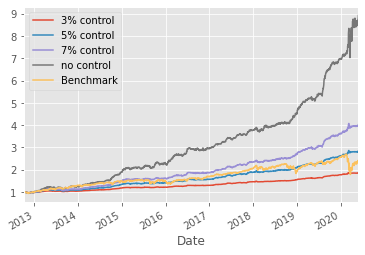

In [23]:
#繪製Volatility Control績效圖
F2 = [(return_list[0] + 1).cumprod(), (return_list[1] + 1).cumprod(), (return_list[2] + 1).cumprod(),  (return_list[3] + 1).cumprod(), (SPY_r + 1).cumprod()]
FP = pd.concat([F2[0], F2[1], F2[2], F2[3], F2[4]], axis=1)
FP.columns = ["3% control", "5% control", "7% control", "no control", "Benchmark"]
FP = FP.reset_index()
FP.plot(x = "Date" ,y =   ["3% control", "5% control", "7% control", "no control", "Benchmark"])

In [24]:
#計算報酬率、標準差、最大回檔
print("MDD:")
for f in F2[:-1]:
    print(((f.cummax() - f)/f.cummax()).max())
print("std:")
for r in return_list:
    print(r.std()*np.sqrt(252))
print("return:")
for f in F2[:-1]:
    print((f.iloc[-1])**(252/len(f)) - 1)

MDD:
0.042151408307216885
0.056256382007288205
0.07732340574114337
0.15728545271986283
std:
0.0333190678973438
0.05380339272018258
0.07057199391034713
0.12241453395273781
return:
0.08494134824116095
0.1463421253491468
0.1998865419268112
0.332111797409385
